In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention,CrossAttention
import sys,os
import seaborn as sns
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()

(Index(['Topic', 'Title', 'article Id', 'Headline'], dtype='object'),
 Index(['Unnamed: 0', 'Topic', 'Article', 'Claim'], dtype='object'),
 522,
 522,
 Index(['authors', 'claim_ids', 'evidence', 'headline', 'id', 'reason',
        'sentences', 'type', 'urls'],
       dtype='object'))

In [4]:
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)

In [5]:
0.8*475

380.0

In [6]:
titles = sorted(df_hd_tp_cdc.Title.unique())
non_test_titles = list(set(titles)-set(test_titles))
val_titles = non_test_titles[380:]
train_titles = titles[:380]
len(train_titles),len(val_titles),len(test_titles)

(380, 95, 47)

In [7]:
train_batchsize = 32
val_batchsize = 32
test_batchsize = 8
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 10000

In [8]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [9]:
def datagen_cdc(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds, ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        hd = dataframe[dataframe.Title==idx]['Headline'].values[0].lower()
        hds.append(hd)
        ar_id = dataframe[dataframe.Title==idx]['article Id'].values[0]
        cl = df_ar_cl_cdc[df_ar_cl_cdc.Article==idx]['Claim'].values
        ar_claims.append(cl)
        sentences=articles[ar_id]
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((1300,300))
        vectors = article_vectors[ar_id]
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
                
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
            


In [10]:
tdg = datagen_cdc(train_batchsize,df_hd_tp_cdc,mode='train')
vdg = datagen_cdc(val_batchsize,df_hd_tp_cdc,mode='val')
test_dg = datagen_cdc(test_batchsize,df_hd_tp_cdc,mode='test')

In [11]:
x,y = next(test_dg)

In [12]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 1300, 300)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1300, 16)     14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1300, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1300, 32)     1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

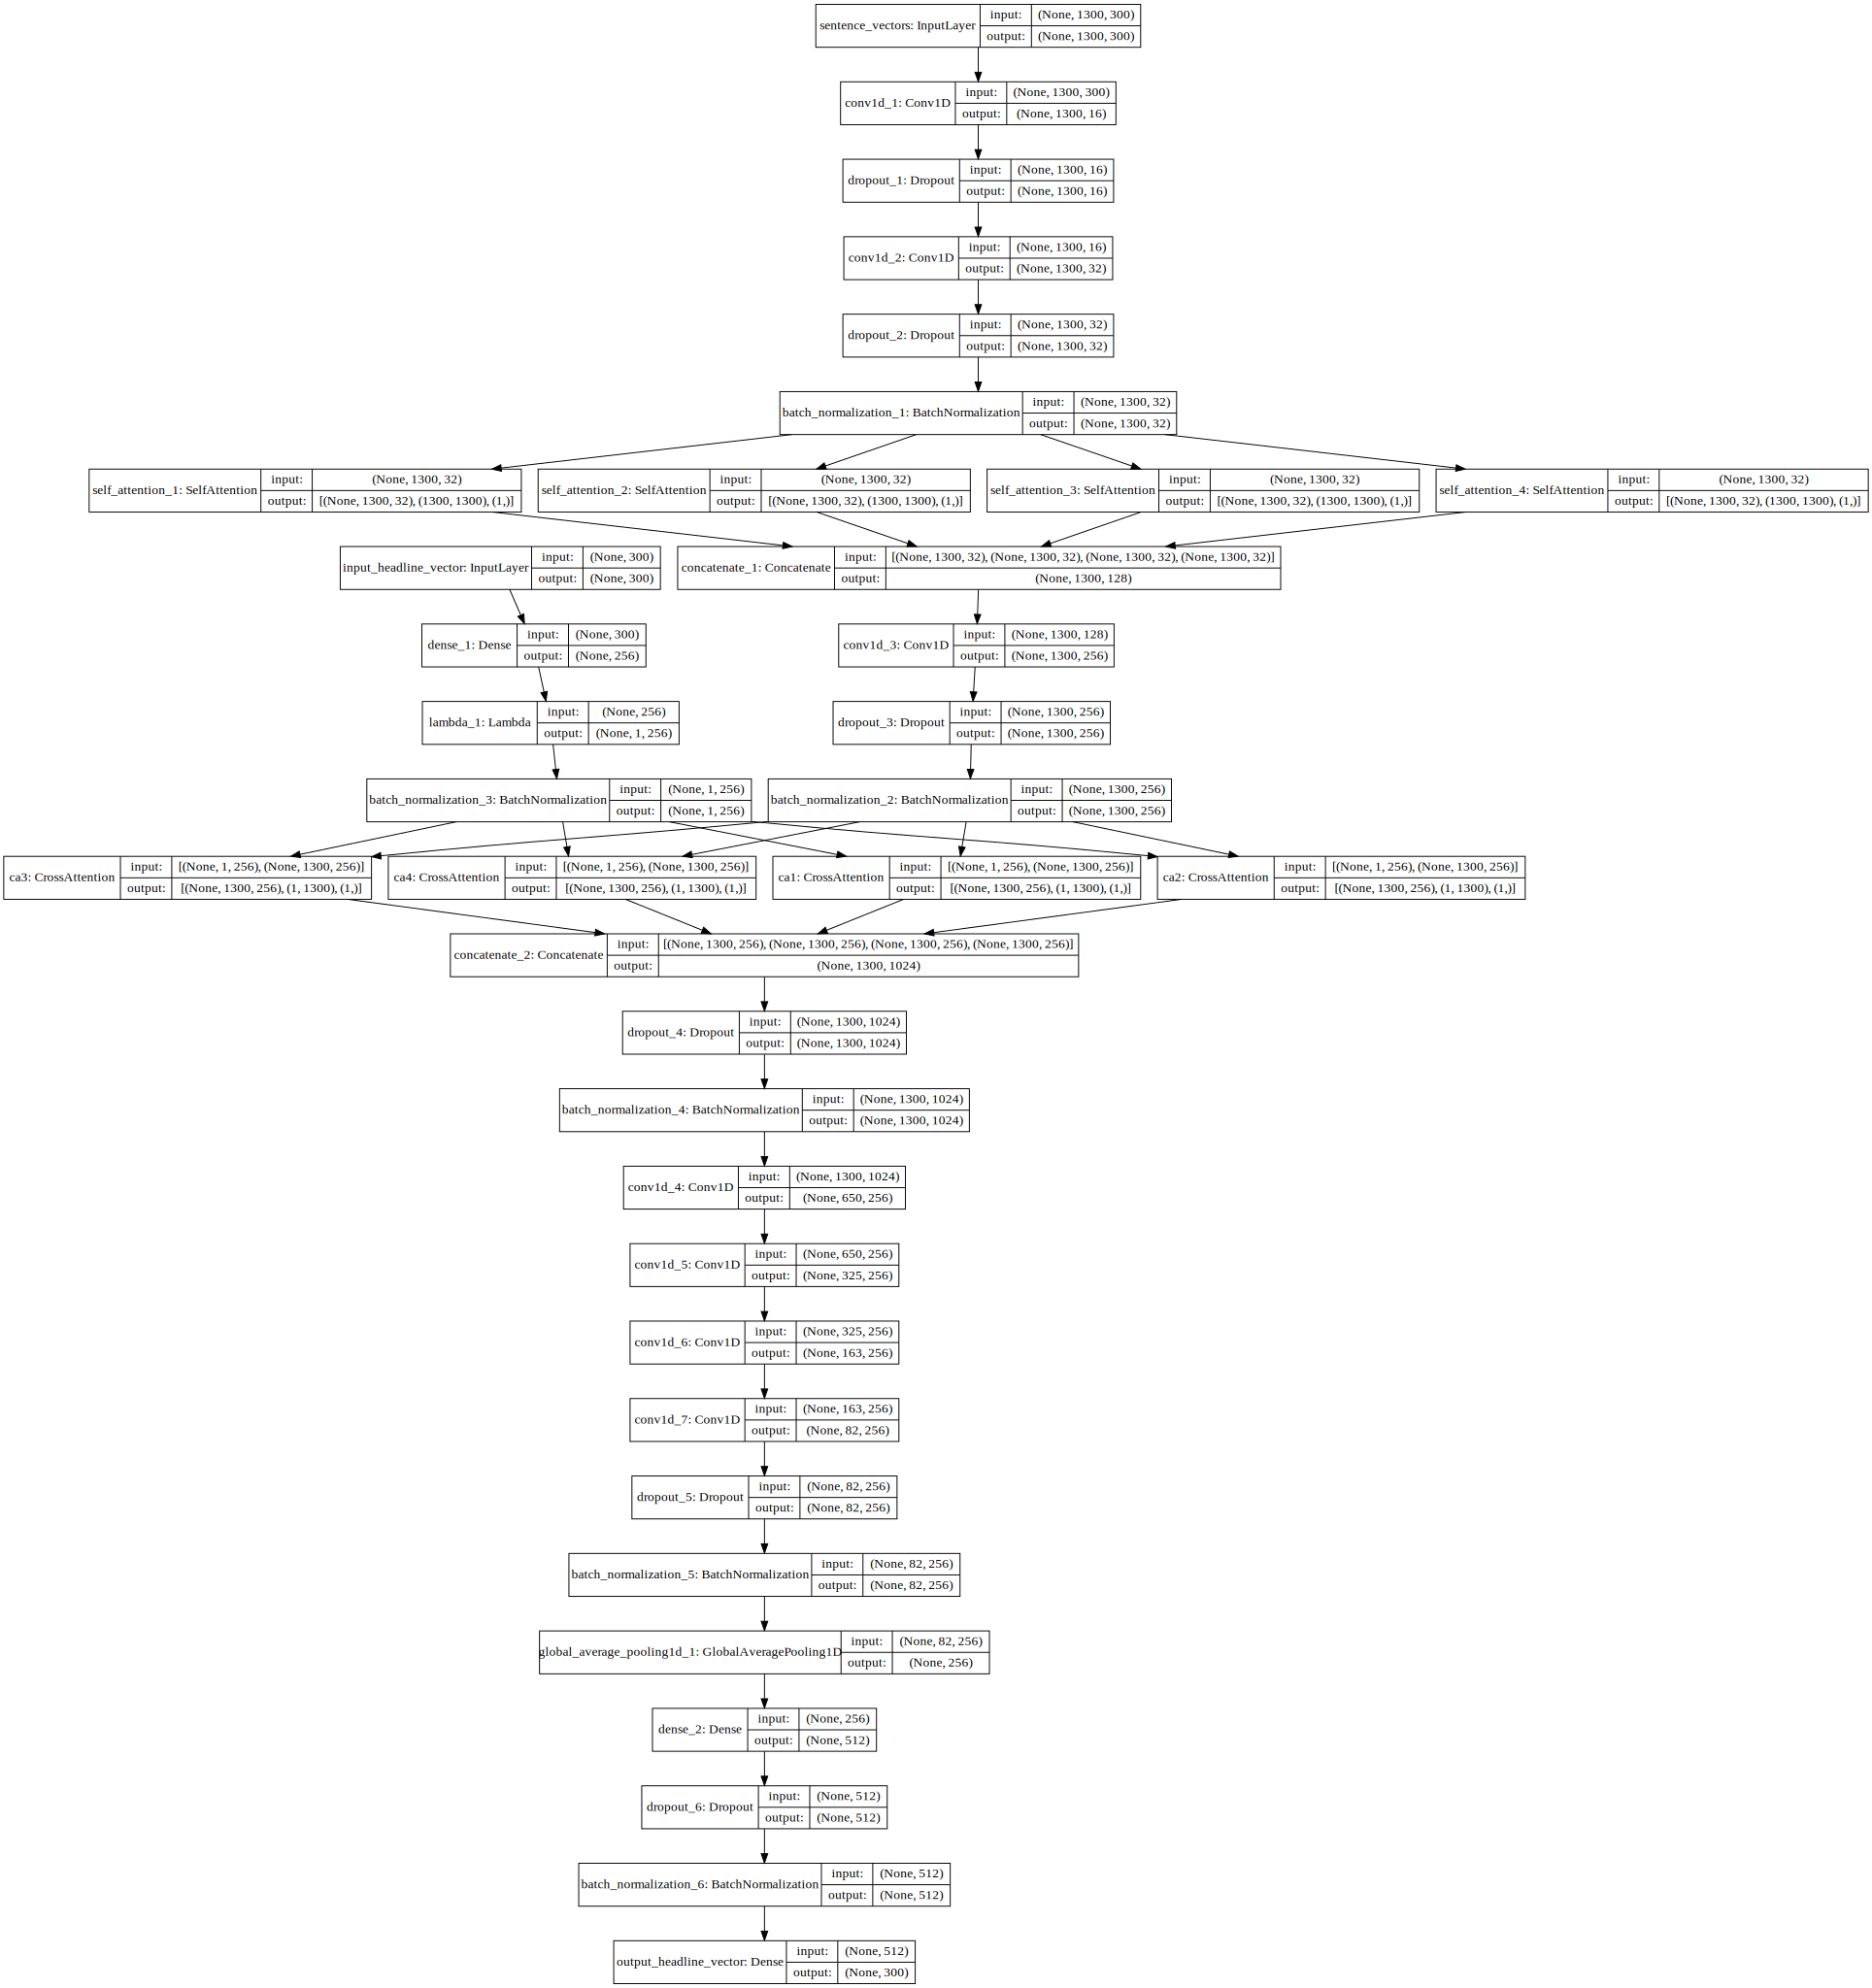

In [12]:
def build_model():
    inp_sentence_vectors = Input(shape=(1300, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]))(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]))(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='mse')
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [14]:
# dt = datetime.now()
# mc = ModelCheckpoint('weights/cdc_sa_sent_hd_vector.hdf5',save_best_only=True,save_weights_only=True)
# tb = TensorBoard(batch_size=32,log_dir='logs/cdc_sa_sent_hd_vector/{0}'.format(dt.timestamp()),write_graph=True)

In [15]:
# hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
#                            ,steps_per_epoch=train_steps_per_epoch
#                            ,validation_data=vdg
#                            ,validation_steps=val_steps_per_epoch
#                            ,epochs=epochs)

In [16]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [17]:
# df_res = pd.DataFrame(hist.history)

In [18]:
# df_res[['loss','val_loss']].plot()

In [19]:

# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [13]:
model.load_weights('weights/cdc_sa_sent_hd_vector.hdf5')
model.evaluate_generator(test_dg,steps=10, pickle_safe = True)

ValueError: Layer #3 (named "self_attention_1" in the current model) was found to correspond to layer self_attention_1 in the save file. However the new layer self_attention_1 expects 9 weights, but the saved weights have 7 elements.

In [21]:
x,y = next(test_dg)
pred = model.predict(x)
pred.shape

(8, 300)

In [22]:
x

{'article_id': array([2384, 2037,    1, 2200, 2435, 2200, 2221, 1352]),
 'claims': array([array(['it violates individual rights',
        'represents slavery and involuntary servitude',
        'Of all the statist violations of individual rights in a mixed economy, the military draft is the worst',
        'It is an abrogation of rights',
        'It negates man’s fundamental right—the right to life',
        'the very conception of a just government in its duty to the citizen includes the reciprocal obligation of the citizen to render military service in case of need',
        'in a cost-to-benefit ratio, conscription during peace time is not worthwhile',
        'Months or years of service amongst the most fit and capable subtracts from the productivity of the economy',
        'The work effort of the conscripts is effectively wasted',
        'professionally-skilled conscripts are also difficult to replace in the civilian workforce',
        'Every soldier conscripted in the army is

In [23]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 1300, 300)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1300, 16)     14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1300, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1300, 32)     1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [64]:
test_idx = 1
print(len(x['sentences'][test_idx]))

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

157


In [65]:
b = b1+b2+b3+b4

In [66]:
best_N = 5
t = b[test_idx][0].argsort()[-best_N:][::-1]
t

array([156, 157, 155, 159, 158])

In [67]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b1[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

157


-16.441559

In [68]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)

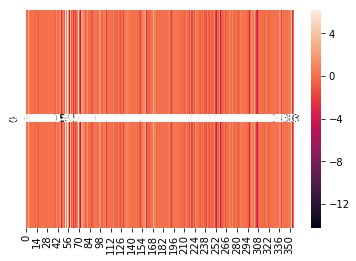

In [69]:
sns.heatmap(df_h_s_attended_vector.T, annot=True,)

In [28]:
x['headline'][test_idx]

'national service should be reintroduced'

In [29]:
x['claims'][test_idx]

array(['it violates individual rights',
       'represents slavery and involuntary servitude',
       'Of all the statist violations of individual rights in a mixed economy, the military draft is the worst',
       'It is an abrogation of rights',
       'It negates man’s fundamental right—the right to life',
       'the very conception of a just government in its duty to the citizen includes the reciprocal obligation of the citizen to render military service in case of need',
       'in a cost-to-benefit ratio, conscription during peace time is not worthwhile',
       'Months or years of service amongst the most fit and capable subtracts from the productivity of the economy',
       'The work effort of the conscripts is effectively wasted',
       'professionally-skilled conscripts are also difficult to replace in the civilian workforce',
       'Every soldier conscripted in the army is taken away from his civilian work, and away from contributing to the economy which funds the milita

In [30]:
for s in t:
    if s>len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

59 : Slaves from the Caucasus served in the army and formed an elite corp of troops.
100 : Since the Cold War was over, so was the direct threat of a war.
258 : |- Germany 349,223 $3,306,000 $40,315.05 81,471,834 federal parliamentary republic No (suspended for peacetime by federal legislature effective from 1 July 2011)
.
53 : The Mamluks were usually captive non-Muslim Iranian and Turkish children who had been kidnapped or bought as slaves from the Barbary coasts.
223 : |- Albania 27,398 $11,800 $2,949.57 2,994,667 Parliamentary Democracy No (abolished in 2010)
.


In [43]:
x['sentences'][test_idx]

['.',
 'Conscription is the compulsory enlistment of people in some sort of national service, most often military service .',
 'Conscription dates back to antiquity and continues in some countries to the present day under various names.',
 'The modern system of near-universal national conscription for young men dates to the French Revolution in the 1790s, where it became the basis of a very large and powerful military.',
 'Most European nations later copied the system in peacetime, so that men at a certain age would serve 1–3 years on active duty, then transfer to the reserve force.',
 'In China, the State of Qin instituted universal military service following the registration of every household .',
 'This allowed huge armies to be levied, and was instrumental in the creation of the Qin Empire that conquered the whole of China in 221BC.',
 'Conscription is controversial, because of conscientious objection to service, or political objection to service for a disliked government, or an un

In [32]:
# df_key_value[df_key_value['value']==1282]['key'].values[0]

In [33]:
# nlp.vocab.vectors.data[1282]

In [34]:
# len(np.unique(list(nlp.vocab.vectors.key2row.keys()))),len(np.unique(list(nlp.vocab.vectors.key2row.values())))

In [35]:
# vocab_dict = {}

In [36]:
# counter = 0
# for s in nlp.vocab.strings:
#     print(s.
#     counter+=1
#     if counter==100:
#         break
    

In [37]:


#     else:
#         print(len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values))

In [38]:
# df_ar_cl_cdc.head()

In [39]:
# sorted(df_hd_tp_cdc.Title.unique())

In [40]:
# sorted(df_ar_cl_cdc.Article.unique())

In [41]:
# for token1,token2 in zip(nlp('how are you hillary!'),nlp('How are You HILLARY!')):
#     print(token1.rank,token2.rank)

In [42]:
# from keras import backend as K
# from keras.layers import Layer,InputSpec
# class CrossAttention(Layer):
#     def __init__(self, ch, **kwargs):
#         super(CrossAttention, self).__init__(**kwargs)
#         self.channels = ch
#         self.filters_q_k = self.channels // 8
#         self.filters_v = self.channels
        
# #         print(kernel_shape_q_k)
# #         print(self.channels,self.filters_f_g,self.filters_h)

#     def build(self, input_shape):
# #         print('input_shape:',input_shape)
#         kernel_shape_q_k = (1, self.channels, self.filters_q_k)
#         kernel_shape_v = (1, self.channels, self.filters_v)
#         self.N = input_shape[1]        
#         self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
#         self.kernel_q = self.add_weight(shape=kernel_shape_q_k,
#                                         initializer='glorot_uniform',
#                                         name='kernel_q', trainable=True)
#         self.kernel_k = self.add_weight(shape=kernel_shape_q_k,
#                                         initializer='glorot_uniform',
#                                         name='kernel_k', trainable=True)
#         self.kernel_v = self.add_weight(shape=kernel_shape_v,
#                                         initializer='glorot_uniform',
#                                         name='kernel_v', trainable=True)
#         self.bias_q = self.add_weight(shape=(self.filters_q_k,),
#                                       initializer='zeros',
#                                       name='bias_q', trainable=True)
#         self.bias_k = self.add_weight(shape=(self.filters_q_k,),
#                                       initializer='zeros',
#                                       name='bias_k', trainable=True)
#         self.bias_v = self.add_weight(shape=(self.filters_v,),
#                                       initializer='zeros',
#                                       name='bias_v', trainable=True)
#         super(CrossAttention, self).build(input_shape)
#         # Set input spec.
# #         self.input_spec = InputSpec(ndim=(3,3),
# #                                     axes={2: input_shape[0][-1],2:input_shape[1][-1]})
# #         self.built = True


#     def call(self, inputs):
#         h,x = inputs
#         q = K.conv1d(h,
#                      kernel=self.kernel_q,
#                      strides=(1,), padding='same')
#         q = K.bias_add(q, self.bias_q)
#         k = K.conv1d(x,
#                      kernel=self.kernel_k,
#                      strides=(1,), padding='same')
#         k = K.bias_add(k, self.bias_k)
#         v = K.conv1d(x,
#                      kernel=self.kernel_v,
#                      strides=(1,), padding='same')
#         v = K.bias_add(v, self.bias_v)
#         print('q.shape,k.shape,v.shape,',q.shape,k.shape,v.shape)
#         s = tf.matmul(q, k, transpose_b=True)  # # [bs, N, N]
#         print('s.shape:',s.shape)
#         beta = K.softmax(s, axis=-1)  # attention map
#         self.beta_shape = tuple(beta.shape[1:].as_list())
#         print('beta.shape:',beta.shape.as_list())
#         o = K.batch_dot(beta, v)  # [bs, N, C]
#         print('o.shape:',o.shape)
# #         o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
#         x = self.gamma * o + x
#         print('x.shape:',x.shape)
#         return [x, beta, self.gamma]

#     def compute_output_shape(self, input_shape):
#         return [input_shape[-1],self.beta_shape, tuple(self.gamma.shape.as_list())]